# In Google Colabo, go to  **"Change runtime type"** and choose **"T4 GPU"** !!

In [18]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

org_data = pd.read_csv(file_path)
org_data = np.array(org_data)

# find missing values
nan_indices = np.where(np.isnan(org_data))

# delete missing values
org_data = np.delete(org_data, nan_indices)

# average and standard deviation
mean_value = np.mean(org_data)
std_dev = np.std(org_data)

# Standardization
org_data = (org_data - mean_value) / std_dev

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# @title Data segmentation

window_size = 1800
segments    = 50

def overlapping_split(org_data, window_size,segments):

    org_data = np.asarray(org_data)
    step_size = 1

    segments = [
        org_data[i * step_size : i * step_size + window_size]
        for i in range(segments)
    ]

    return np.array(segments)

data = overlapping_split(org_data, window_size,segments)
print(data.shape)

(50, 1800)


In [20]:
# @title Loading optuna and libraries

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv
import datetime

!pip install optuna
import optuna

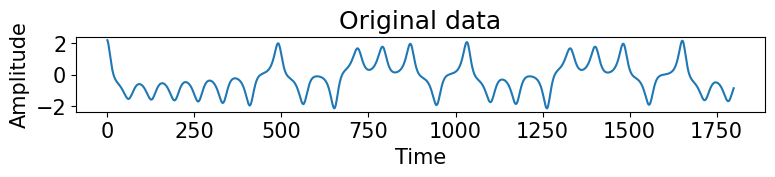

Data shape: (50, 1800)


In [21]:
# @title Visualization

plt.figure(figsize=(8, 3))
plt.subplot(2, 1, 1)
plt.plot(data[0,:])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

print('Data shape:',data.shape)

In [22]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low  = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction      = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

########################

import numpy as np

def get_Wout_opt_batch(X_XT,D_XT,beta):

    Wout_opt = np.zeros((X_XT.shape[0], D_XT.shape[1], X_XT.shape[1]))

    for b in range(X_XT.shape[0]):
        Wout_opt[b] = (np.linalg.solve((X_XT[b] + beta * np.identity(X_XT.shape[1])).T, D_XT[b].T)).T

    return Wout_opt


###################
#Definition of batch learning (convexity)
###################

from numba import njit

@njit
def train_1d(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):
    x = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))

    X_XT_segments = np.zeros((train_U.shape[0]-T_train, N_x, N_x))
    D_XT_segments = np.zeros((train_U.shape[0]-T_train, dim, N_x))
    x_special_vec  = np.zeros((train_U.shape[0]-T_train, N_x))

    for n in range(train_U.shape[0]-1):
        # Reservoir update
        u = train_U[n,:]
        x_in = Win @ u
        x = (1 - alpha) * x + alpha * np.tanh(W @ x + x_in + bias_scale)

        d = train_D[n,:]

        if n > discard_len:
            X_XT += np.outer(x, x)
            D_XT += np.outer(d, x)

        if n >= T_train-1:
            X_XT_segments[n-T_train+1,:,:] = X_XT
            D_XT_segments[n-T_train+1,:,:] = D_XT
            x_special_vec[n-T_train+1,:]   = x

    return X_XT_segments, D_XT_segments, x_special_vec


########################
#induction formula for creating estimated data
########################

def run_batch(test_U, x_special_vec, Win, W, Wout, alpha, T_test, bias_scale):
    M, Nu = test_U.shape
    Nx = x_special_vec.shape[1]
    Ny = Wout.shape[1]

    Y_pred = np.zeros((M, Ny, T_test))

    # initialization

    x = x_special_vec.copy()  # shape (M, Nx)
    y = test_U.copy()         # shape (M, Nu)

    for n in range(T_test):

        x_in = y @ Win.T        # shape (M, Nx)
        Wx = x @ W.T            # shape (M, Nx)

        x = (1 - alpha) * x + alpha * np.tanh(Wx + x_in + bias_scale)

        # Wout[m,:,:] @ x[m,:]
        y_pred = np.einsum('mij,mj->mi', Wout, x)  # shape (M, Ny)

        Y_pred[:, :, n] = y_pred
        y = y_pred

    return Y_pred

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):

    mae = mean_absolute_error(data1_in, data2_in)
    return mae

In [23]:
# @title Definition of implementation of train and test

def impl_train_test(T_train,impl_set,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test):


    data_delay_train = np.zeros((T_train+impl_set.shape[0]+1,dim), dtype=float)

    #Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

    ##########################################
    #Convert training data to a delay coordinate system

    for i in range(dim):

        data_delay_train[:,i] = org_data[T_0-T_train-i*lag:T_0+impl_set.shape[0]-i*lag+1] # i*lag Step-delayed time series


    # Initialization of training data

    train_U = np.zeros((T_train+impl_set.shape[0],dim), dtype=float)
    train_D = np.zeros((T_train+impl_set.shape[0],dim), dtype=float)

    #Input/output of training data

    train_U = data_delay_train[:T_train+impl_set.shape[0],:]
    train_D = data_delay_train[1:T_train+impl_set.shape[0]+1,:]

    ##The last time data of the training data output must overlap with the test data,
    ##since non-increment online learning!

    #Ridge
    X_XT_segments = np.zeros((impl_set.shape[0],N_x, N_x))
    D_XT_segments = np.zeros((impl_set.shape[0],dim, N_x))
    x_special_vec = np.zeros((impl_set.shape[0],N_x))

    X_XT_segments, D_XT_segments,x_special_vec = train_1d(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,discard_len,bias_scale)

    # Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt_batch(X_XT_segments, D_XT_segments,beta)



    #######################
    # Model selection phase
    test_Y           = np.zeros((impl_set.shape[0],dim,T_test))
    test_D           = np.zeros((impl_set.shape[0],dim,T_test))
    data_delay_test         = np.zeros((impl_set.shape[0],dim,T_test+1), dtype=float)
    tentative_test_Y        = np.zeros((T_test,dim))

    #Convert training data to a delay coordinate system (to create reservoir state vec)


##############################
#test in model selection phase

    for i in range(dim):

        data_delay_test[:,i,:] = impl_set[:,T_0-i*lag:
                                        T_0+T_test-i*lag+1] # i*lag step delayed time series


#Generate estimated data


        test_Y[:,:,:] = run_batch(data_delay_test[:,:,0],x_special_vec[:,:], \
                                      Win,W,Wout[:,:],alpha,T_test,bias_scale)
        test_D[:,:,:] = data_delay_test[:,:,1:T_test+1]

    return np.abs(test_Y[:,0,T_test-1]-test_D[:,0,T_test-1]), test_Y, test_D


In [24]:
# @title Hyperparameters

T_train      = 1500  # Training period
T_test       = 100     # Forecast period
discard_len  = 10    # Number of steps not learned at the beginning (not important)
initial_time = 0     # Starting training time

In [25]:
# @title Hyperparameters: Bayesian optimization for Reservoir

Node       = 150   # Reservoir Node
max_lag    = 10    # Maximum of lag for delay coordinate
max_dim    = 15    # Maximum of dimension for delay coordinate

###################
save_to_csv = False  #True or False ← Set to False to skip file creation/writing
###################

In [26]:
# @title Implement set

impl_set = data[:,initial_time:initial_time+T_train+max_lag*max_dim+2*T_test]

print("data length from initial_time:",data[:,initial_time:].shape[1])
print("shape of implement set",impl_set.shape)

data length from initial_time: 1800
shape of implement set (50, 1800)


In [27]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

"""
Make sure that the parameter search space is identical
between the "frozen trial" section and the "objective function" section!!

"""
####################
n_trials    = 50   # Number of times to test with optuna (generate MAE for this number of times)
####################

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

#####################################################
#We can load (in csv file) and reuse the past trials

file_path = 'reservoir.csv'
past_trials = []
if os.path.exists(file_path):


# Import data from CSV files

   with open(file_path, mode='r', newline='') as file:
       reader = csv.DictReader(file)
       for row in reader:
        # Data processing and incorporation into past_trials
           trial_data = {
               'value': float(row['value']),
               'params': {
                   'lag': int(row['lag']),
                   'dim': int(row['dim']),
                   'N_x': int(row['N_x']),
                   'beta': float(row['beta']),
                   'density': float(row['density']),
                   'input_scale': float(row['input_scale']),
                   'rho': float(row['rho']),
                   'alpha': float(row['alpha']),
                   'seed_value': float(row['seed_value']),
                   'bias_scale': float(row['bias_scale'])
               }
           }
           past_trials.append(trial_data)


# Creating an Optuna Study
study = optuna.create_study(direction="minimize")


############################
# Add past attempts to study
for trial in past_trials:

    if 'value' not in trial:
        print(f"Skipping trial as it does not contain 'value': {trial}")
        continue

    try:
          value = float(trial['value'])
    except ValueError as e:
          print(f"Error converting trial value to float: {e}")
          continue  # Proceed to the next TRIAL

    trial_id = len(study.trials)

    frozen_trial = FrozenTrial(
      number=trial_id,  # trial number
      state=TrialState.COMPLETE,
      value=trial['value'],
      datetime_start=datetime.now(),
      datetime_complete=datetime.now(),
      params=trial['params'],
      distributions={
          'lag': optuna.distributions.IntUniformDistribution(3, max_lag),
          'dim': optuna.distributions.IntUniformDistribution(3, max_dim),
          'N_x': optuna.distributions.IntUniformDistribution(Node, Node),
          'beta': optuna.distributions.FloatDistribution(0.0001, 0.0001),
          'density': optuna.distributions.FloatDistribution(0.001, 1),
          'input_scale': optuna.distributions.FloatDistribution(0, 1.5),
          'rho': optuna.distributions.FloatDistribution(0, 1.5),
          'alpha': optuna.distributions.FloatDistribution(0, 1),
          'seed_value': optuna.distributions.FloatDistribution(0, 100),
          'bias_scale': optuna.distributions.FloatDistribution(-1.5, 1.5)
      },
      user_attrs={},
      system_attrs={},
      intermediate_values={},
      trial_id=trial_id
    )
    study.add_trial(frozen_trial)
#################################
# Objective Function Definition

def objective(trial):
    lag = trial.suggest_int("lag", 3, max_lag)
    dim = trial.suggest_int("dim", 3, max_dim)
    N_x = trial.suggest_int("N_x", Node, Node)                #Initially fixed here
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho = trial.suggest_float("rho", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)
    bias_scale = trial.suggest_float("bias_scale", -1.5, 1.5)

#############################
#Test start time (model selection)

    T_0 = T_train + lag * (dim-1)

#Initialization of estimated data

    mae,_,_ = impl_train_test(T_train,impl_set,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test)

    return np.mean(mae)


#############
# Perform optimization
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

###################
# Write to CSV file

current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'reservoir.csv')

if save_to_csv:

    # Write additional CSV files with the latest trial data

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

    # Writing header lines (first time only)
        if file.tell() == 0:
            writer.writerow(['value', 'lag', 'dim', 'N_x', 'beta', 'density', 'input_scale', 'rho', 'alpha', 'seed_value', 'bias_scale'])

        # Write all trials
        for trial in study.trials:
            lag_value = trial.params.get('lag')
            if lag_value is not None:  # Write only if lag is not None
              writer.writerow([
        #trial.number,
        trial.value,
        trial.params.get('lag', None),
        trial.params.get('dim', None),
        trial.params.get('N_x', None),
        trial.params.get('beta', None),
        trial.params.get('density', None),
        trial.params.get('input_scale', None),
        trial.params.get('rho', None),
        trial.params.get('alpha', None),
        trial.params.get('seed_value', None),
        trial.params.get('bias_scale', None)
    ])

[I 2025-09-15 10:57:56,478] A new study created in memory with name: no-name-6661da94-1e81-4a5d-bc05-ebdbfc4a882a
[I 2025-09-15 10:57:59,763] Trial 0 finished with value: 1.3158878323994143 and parameters: {'lag': 3, 'dim': 8, 'N_x': 150, 'beta': 0.0001, 'density': 0.5556495594680841, 'input_scale': 0.13299470603665264, 'rho': 0.6277000048012844, 'alpha': 0.18275869073776863, 'seed_value': 99.63798620153865, 'bias_scale': -0.5394367857405372}. Best is trial 0 with value: 1.3158878323994143.
[I 2025-09-15 10:58:01,138] Trial 1 finished with value: 1.4716387473964145 and parameters: {'lag': 8, 'dim': 8, 'N_x': 150, 'beta': 0.0001, 'density': 0.4867110574685361, 'input_scale': 1.377162017554897, 'rho': 0.5424581907750812, 'alpha': 0.7379386504358675, 'seed_value': 15.96050537229744, 'bias_scale': -0.11047689897252333}. Best is trial 0 with value: 1.3158878323994143.
[I 2025-09-15 10:58:10,659] Trial 2 finished with value: 1.7990635000321384 and parameters: {'lag': 5, 'dim': 15, 'N_x': 150

Best trial:
  'params': {'lag': 3, 'dim': 11, 'N_x': 150, 'beta': 0.0001, 'density': 0.541552440575704, 'input_scale': 0.822190419674212, 'rho': 0.43459965132314754, 'alpha': 0.074470232788871, 'seed_value': 9.219993203940271, 'bias_scale': -0.9104900300510952},
  'value': 0.07234820733583217,
CPU times: user 1min 3s, sys: 308 ms, total: 1min 4s
Wall time: 1min 1s


In [28]:
# @title Best hyperparameters

best_params = study.best_params

lag          = best_params["lag"]
dim          = best_params["dim"]
N_x          = best_params["N_x"]
beta         = best_params["beta"]
density      = best_params["density"]
input_scale  = best_params["input_scale"]
rho          = best_params["rho"]
alpha        = best_params["alpha"]
seed_value   = best_params["seed_value"]
bias_scale   = best_params["bias_scale"]

print(f"initial_time= {initial_time}")
print(f"max_lag= {max_lag}")
print(f"max_dim= {max_dim}")
print(f"lag= {lag}")
print(f"dim= {dim}")
print(f"N_x= {N_x}")
print(f"beta= {beta}")
print(f"density= {density}")
print(f"input_scale= {input_scale}")
print(f"rho= {rho}")
print(f"alpha= {alpha}")
print(f"seed_value= {seed_value}")
print(f"bias_scale= {bias_scale}")


initial_time= 0
max_lag= 10
max_dim= 15
lag= 3
dim= 11
N_x= 150
beta= 0.0001
density= 0.541552440575704
input_scale= 0.822190419674212
rho= 0.43459965132314754
alpha= 0.074470232788871
seed_value= 9.219993203940271
bias_scale= -0.9104900300510952


In [29]:
# @title Data Segmentation Again

windw_size = 1800
segments = 3000

data = overlapping_split(org_data, window_size,segments)
impl_set = data[:,initial_time:initial_time+T_train+max_lag*max_dim+2*T_test]

print("data length from initial_time:",data[:,initial_time:].shape[1])
print("shape of implement set",impl_set.shape)

data length from initial_time: 1800
shape of implement set (3000, 1800)


In [30]:
# @title Model Evaluation phease

%%time

###############################
#Test start time (model evaluation)
#NOT T_0 = T_train+lag*dim!!

T_0 = T_train+lag*(dim-1)+T_test

mae,test_Y,test_D = impl_train_test(T_train,impl_set,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test)

mae_mean = np.mean(mae)

CPU times: user 45.5 s, sys: 755 ms, total: 46.2 s
Wall time: 45.7 s


MAE mean: 0.051337236918532834
forecast period: 100


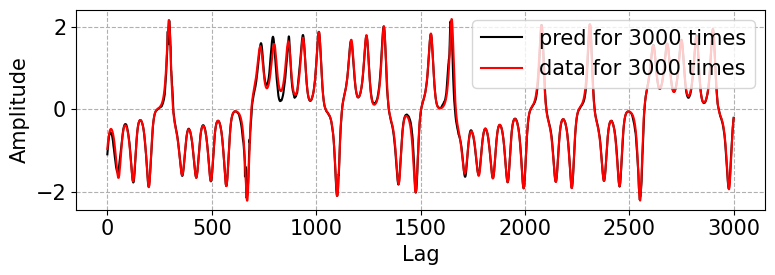

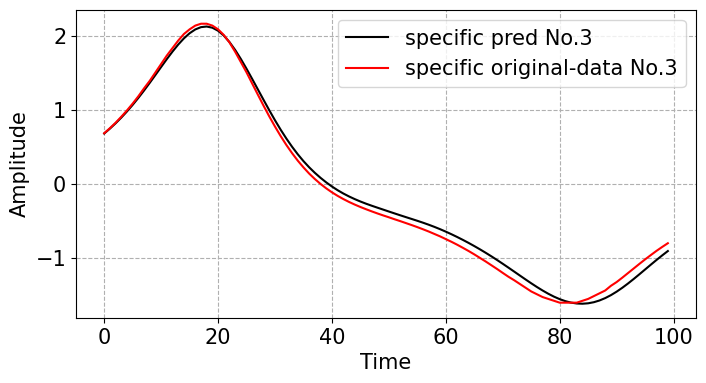

In [31]:
# @title Visualization

#print("MAE:", mae)
print("MAE mean:", mae_mean)
print("forecast period:", T_test)


fig = plt.figure(figsize=(8,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.plot(test_Y[:,0,T_test-1], color="black", label=f"pred for {test_Y.shape[0]} times")
plt.plot(test_D[:,0,T_test-1], color = "red",label=f"data for {test_D.shape[0]} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()


fix_test_num =3

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[fix_test_num,0,:], color = "black",label=f"specific pred No.{fix_test_num}")
plt.plot(test_D[fix_test_num,0,:], color = "red",label=f"specific original-data No.{fix_test_num}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()